In [32]:
import Simulation as sim
import IrisUtils as irisUtils
import GcsTrajectoryUtils as gcsUtils

import numpy as np

import time



In [33]:


PATH_TO_OBSTACLE_ENV = "models/obstacles_house_formation.urdf"

# width of ground, lenght of ground,height of highest obstavle + 1. Look in urdf file
center_ground_xy = np.array([0, 5]) 
ground_width = 7
ground_length = 15
obst_height = 2

obstacle_ScaleFactor=1.3

# trajectory
kdimentions = 3
vel_lower_bound = np.ones(kdimentions) * -.1
vel_upper_bound =  np.ones(kdimentions) * 7 #np.array([100000, 100000, 100000])





################ Building environment model ################

Obstacles loaded


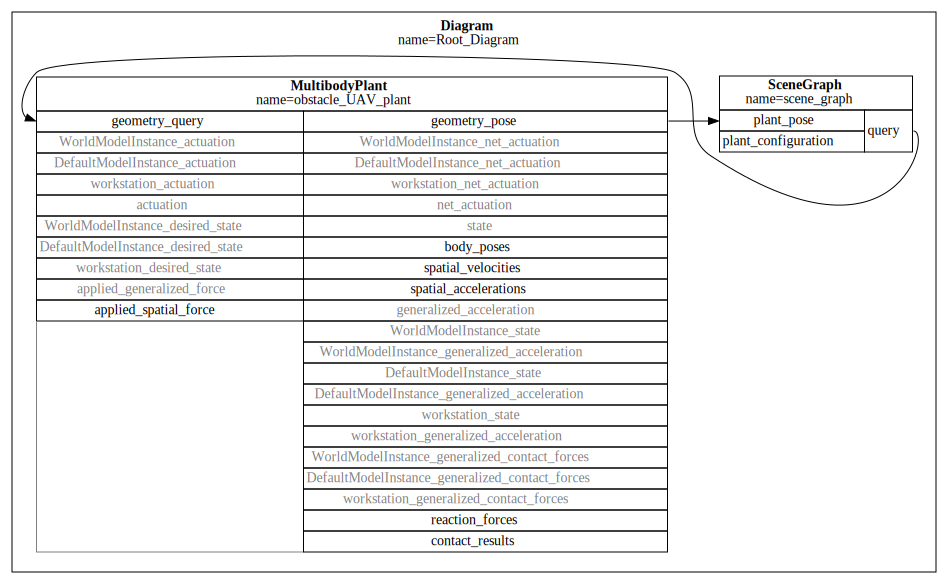

Model Instances and Bodies:

Model Instance: WorldModelInstance
  Body Name: world
Model Instance: DefaultModelInstance
Model Instance: workstation
  Body Name: ground
  Body Name: obs1
  Body Name: obs2
  Body Name: obs3
  Body Name: obs4
  Body Name: obs5
  Body Name: obs6
Number of model instances:  3
Number of bodies:  8

################ FINISHED building environment model ################




In [34]:


print("################ Building environment model ################\n")
simEnv = sim.SimulationEnvironment(obstacle_load_path=PATH_TO_OBSTACLE_ENV)
# simEnv.connect_meshcat()
simEnv.build_model()
simEnv.save_and_display_diagram()
sim.print_model_instances(simEnv.plant)
print("################ FINISHED building environment model ################\n\n")




In [35]:
# Solve IRIS
print("################ Starting IRIS region computation ################\n")
irisOptions = irisUtils.IrisWrapperOptions()
irisOptions.use_CliqueCover = True
irisOptions.num_regions = 10
irisOptions.obstacle_offset_factor = obstacle_ScaleFactor
irisOptions.seed = 0
irisOptions.region_file_path = "region_files/iris_regions"
irisOptions.clique_num_points = 200

irisWrapper = irisUtils.IrisWrapper(irisOptions)    
simEnv.compute_obstacles(irisWrapper)
irisWrapper.determine_and_set_domain(center_ground_xy, ground_width, ground_length, obst_height)    

# irisWrapper.add_meshVisualization_iris_obstacles(simEnv.meshcat, is_visible=True)
# irisWrapper.add_meshVisualization_iris_domain(simEnv.meshcat, is_visible=True)


if irisWrapper.load_regions_from_file() is None:
        
    irisWrapper.solveIRIS()
    irisWrapper.save_regions_to_file()

irisWrapper.add_meshVisualization_iris_regions(simEnv.meshcat, is_visible=True) 


print("################ FINISHED IRIS computation ################\n\n")

# Save the regions to a file




################ Starting IRIS region computation ################

Regions loaded from region_files/iris_regions_clique.pkl
################ FINISHED IRIS computation ################




In [43]:

print("################ Solving GCS trajectory ################\n")
options = gcsUtils.GCSTrajectoryOptions()
options.use_BezierGCS = False
options.regions = irisWrapper.iris_regions
options.path_continuity_order = 4 # 3 works
options.Bspline_order = 5   # 4 works
# options.edges = None

options.start_velocity_lb = np.array([0.9, 0.9, 0.9])
options.goal_velocity_lb = np.array([0.1, 0.5, 0.1])


options.hdot_min = 1e-3
options.full_dim_overlap = True
options.traj_file_path = 'trajectory_files/trajectory'
options.derivative_regularization = 1e-3

gcsTraj = gcsUtils.GCSTrajectory(3, options)
start = [0, 0, 1]
goal = [0.5, 11.5, 1.5]
# goal = [0, 10.5, 1.5]

source_target_vel = np.array([[10, 1, 0], [10,1,0]])
gcsTraj.add_start_goal_and_viz(start, goal, simEnv.meshcat, velocity=source_target_vel,  zero_deriv_boundary=None)
gcsTraj.add_pathLengthCost(100)
gcsTraj.add_timeCost(1)
gcsTraj.add_velocityBounds(vel_lower_bound, vel_upper_bound)
gcsTraj.add_continuityContraint()


# input("Press Enter to solve the trajectory...")
if gcsTraj.load_trajectory_from_file() is None:
    gcsTraj.solve(preprocessing=False)   
    gcsTraj.save_trajectory_to_file()
    
num_points = 2000
gcsTraj.visualize_trajectory(simEnv.meshcat, num_points)

print("################ FINISHED solving GCS tracjectory  ################\n\n")




################ Solving GCS trajectory ################

adding C1 constraints
adding C2 constraints
adding C3 constraints
adding C4 constraints
Regions not loaded from trajectory_files/trajectory.pkl
Error: Ran out of input


INFO:drake:Solved GCS shortest path using Mosek with convex_relaxation=true and preprocessing=true and rounding.
INFO:drake:Finished 10000 rounding trials.


Solution found after  2.4 seconds


Saving trajectory to file
Saving non Bezier trajectory to file
Failed to save trajectory to trajectory_files/trajectory.pkl
Error: cannot pickle 'pydrake.trajectories.CompositeTrajectory' object
################ FINISHED solving GCS tracjectory  ################




In [44]:
import pickle

        
gcsTraj2 = None
path = "./trajectory_files/trajectory3_BezierGCS.pkl"
with open(path, 'rb') as f:
    gcsTraj2 = pickle.load(f)



# trajectory = gcsTraj2
trajectory = gcsTraj.trajectory



INFO:drake:Meshcat listening for connections at http://localhost:7004


################ Starting Simulation ################


Obstacles loaded


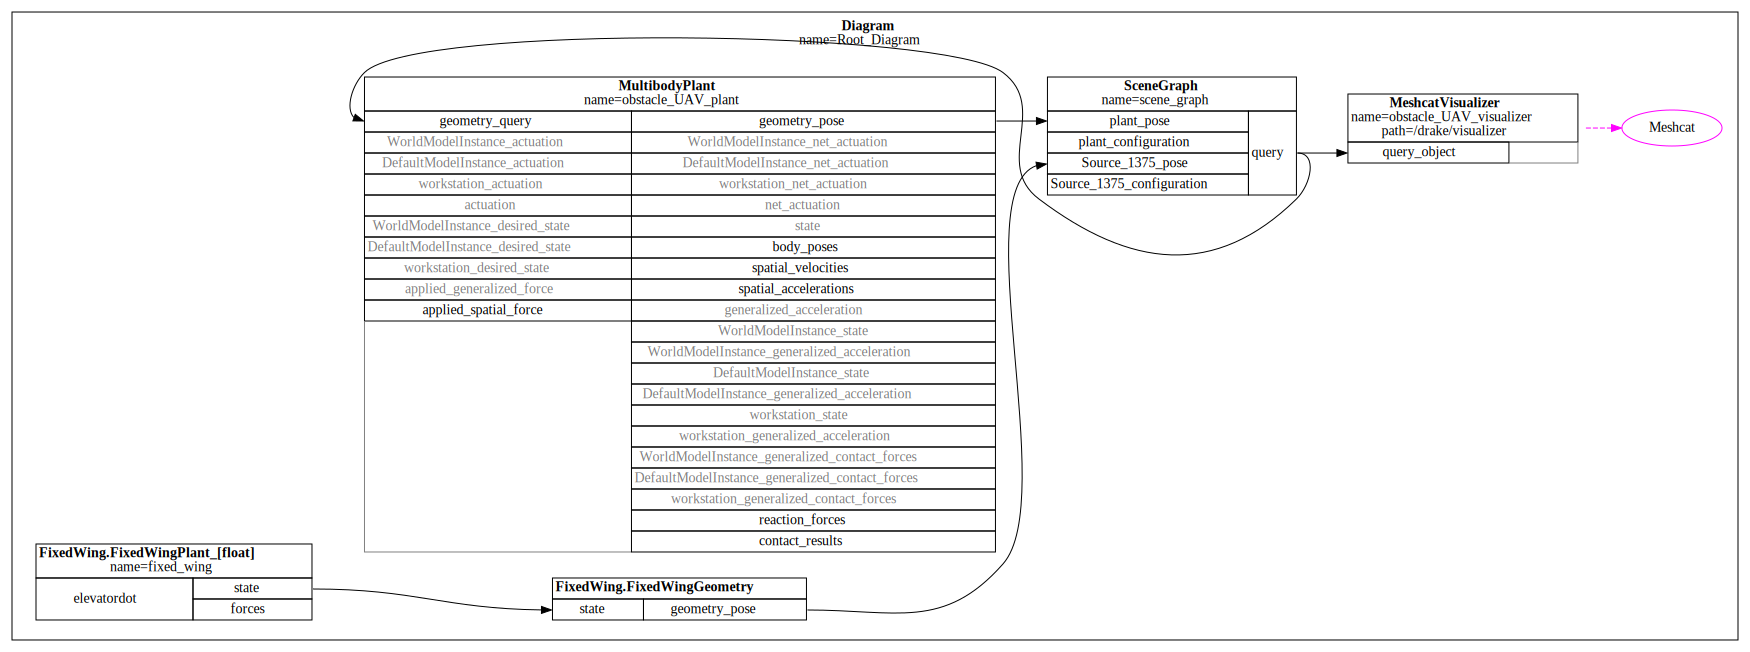

Model Instances and Bodies:

Model Instance: WorldModelInstance
  Body Name: world
Model Instance: DefaultModelInstance
Model Instance: workstation
  Body Name: ground
  Body Name: obs1
  Body Name: obs2
  Body Name: obs3
  Body Name: obs4
  Body Name: obs5
  Body Name: obs6
Number of model instances:  3
Number of bodies:  8

################ FINISHED Simulation ################




In [45]:


print("################ Starting Simulation ################\n\n")

simulator = sim.SimulationEnvironment(PATH_TO_OBSTACLE_ENV)
simulator.connect_meshcat()
simulator.add_fixed_wing()
simulator.add_controller(gcsTraj.trajectory.value(6))
simulator.build_model()
simulator.save_and_display_diagram(save=False)


sim.print_model_instances(simulator.plant)

# Visualization
irisWrapper.add_meshVisualization_iris_regions(simulator.meshcat, is_visible=True) 
gcsTraj.visualize_start_goal(start, goal, simulator.meshcat)
gcsTraj.visualize_trajectory(simulator.meshcat, num_points)
irisWrapper.add_meshVisualization_iris_obstacles(simulator.meshcat, is_visible=False)
irisWrapper.add_meshVisualization_iris_domain(simulator.meshcat, is_visible=True)

simulator.simulate(5)


# s0 = pp.GliderState(np.zeros(7))
# s0.x = -3.5
# s0.z = 0.1
# s0.xdot = 7.0

# pp.draw_glider(s0[:], simulator.meshcat )

print("################ FINISHED Simulation ################\n\n")



In [46]:
from underactuated.meshcat_utils import AddMeshcatTriad

def visualize_frame(name, X_WF, length=0.15, radius=0.003):
    """
    visualize imaginary frame that are not attached to existing bodies

    Input:
        name: the name of the frame (str)
        X_WF: a RigidTransform from frame F to world.

    Frames whose names already exist will be overwritten by the new frame
    """
    AddMeshcatTriad(
        simulator.meshcat, "traj_source/" + name, length=length, radius=radius, X_PT=X_WF
    )

    # print("Visualized frame: ", X_WF)

## Visualization of key frames:
def visualize_key_frames(frame_poses):
    simulator.meshcat.Delete("traj_source/")
    for i, pose in enumerate(frame_poses):
        visualize_frame("frame_{}".format(i), pose, length=0.3)
        
        




# FlatnessInverter

In [47]:
from pydrake.common.containers import namedview 

from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix

import numpy as np

# from pydrake.all import (
#     RotationMatrix
# )


# To test
import GeometryUtils as geoUtils 
from pydrake.geometry import Rgba


# Implemented in accordance with notation from https://thesis.unipd.it/retrieve/a2c7ed88-c8a9-47ad-8a4c-798b2a4c345e/Pasquali_Monika.pdf

FixedWingStatesNED = namedview(
    "FixedWingNStatesNED", ["x", "y", "z", "v_a", "betha", "alpha", "chi", "gamma", "mu", "p", "q", "r"]
)

# Center of gravity of the aircraft
CoG = namedview(
    "CoG", ["x", "y", "z"]
)


def ConvertToNEDcoordinate(p_Dr,dp_Dr,ddp_Dr,dddp_Dr):
    
    X_IDr = RigidTransform(RotationMatrix.MakeXRotation(-np.pi))
    
    p_ned = X_IDr @ p_Dr
    dp_ned = X_IDr @ dp_Dr
    ddp_ned = X_IDr @ ddp_Dr
    dddp_ned = X_IDr @ dddp_Dr
    
    return p_ned, dp_ned, ddp_ned, dddp_ned
    

ind = 0 
 
def UnflattenFixedWingStatesNED(p_Dr,dp_Dr,ddp_Dr,dddp_Dr, m, g):
    
    '''
    input: x: np.array of shape (3,)
    '''
    global ind
    p, dp, ddp, dddp = ConvertToNEDcoordinate(p_Dr,dp_Dr,ddp_Dr,dddp_Dr)
    
    
    
    geoUtils.visualize_point(simulator.meshcat, p, label=f"test/p_{ind}", radius=0.01, color=Rgba(.06, 0, 0, 1)) 
    ind +=1
    
    s = FixedWingStatesNED(np.zeros(12))
    
    p_n = CoG(p)
    dp_n = CoG(dp)
    ddp_n = CoG(ddp)
    dddp_n = CoG(dddp)
    
    
    
    s[0:3] = p  # x, y, z
    
    s.v_a = np.sqrt( dp.T @ dp) 
    
    s.betha = 0 # assumed 0 for fixed wing
    
    s.alpha = 0 # assumed 0 for now  # np.arctan2(dx[2], dx[0])
    
    s.gamma = np.arcsin(- dp_n.z/s.v_a)
    
    s.chi = np.arctan2(dp_n.y, dp_n.x)
    
    
    dx_ddx = dp_n.x * ddp_n.x
    dy_ddy = dp_n.y * ddp_n.y
    dz_ddz = dp_n.z * ddp_n.z
    sum_dt_p = dx_ddx + dy_ddy + dz_ddz
    
    
    dv_a = sum_dt_p / s.v_a # PAPER says s.v_a**2, but I think it should be s.v_a
    
    
    d_dx_ddx = ddp_n.x**2 + dp_n.x*dddp_n.x
    d_dy_ddy = ddp_n.y**2 + dp_n.y*dddp_n.y
    d_dz_ddz = ddp_n.z**2 + dp_n.z*dddp_n.z
    
    sum_ddt_p = d_dx_ddx + d_dy_ddy + d_dz_ddz
    
    ddv_a = (sum_ddt_p*s.v_a - sum_dt_p * dv_a ) / s.v_a**2  # PAPER says something else, but I think it might be a propagation error from dv_a
    
    sqrt_exp = np.sqrt(1 - (dp_n.z/s.v_a)**2) 
    dgamma = - ddp_n.z/(s.v_a * sqrt_exp) + dp_n.z*dv_a / (s.v_a**2 * sqrt_exp) # SAME AS PAPER
    
    
    f = dp_n.x * ddp_n.y - dp_n.y * ddp_n.x
    g = dp_n.x**2 + dp_n.y**2
    dchi = f / g # SAME AS PAPER
    
    df = dddp_n.y*dp_n.x - dddp_n.x*dp_n.y 
    dg = 2*dp_n.x*ddp_n.x + 2*dp_n.y*ddp_n.y
    ddchi = (df*g - f*dg ) / g**2 # SAME AS PAPER
    
    
    t = s.v_a * m * np.cos(s.gamma) * dchi
    b = s.v_a * m * dgamma + np.cos(s.gamma)*g*m
    s.mu = np.arctan2(t, b) # FROM PAPER
    
    print(f"z_dot: {dp_n.z}")
    print(f"s.v_a: {s.v_a}, sqrt_exp: {sqrt_exp}, s.b : {b}")
    
            
    
    return s[:]


def ExtractTransformationNED(statesNED):
    
    s = FixedWingStatesNED(statesNED)
    R_OA = RollPitchYaw(s.mu, s.gamma, s.chi).ToRotationMatrix()
    
    R_BA = RotationMatrix.MakeYRotation(-s.alpha) @ RotationMatrix.MakeZRotation(s.betha)
    
    R_OB = R_OA @ R_BA.transpose()  
    
    # print(f"s.chi: {s.chi}, s.gamma: {s.gamma}, s.mu: {s.mu}")
    print("R_OB: ", R_OB)
    
    # R_OB_temp = R_OB @ RotationMatrix.MakeXRotation(np.pi/2)
    # R_OB = R_IB
    X_IB = RigidTransform(R_OB, s[0:3])


    return X_IB 
    

def ExtractTransformation(statesNED):
    
    X_IB = ExtractTransformationNED(statesNED)
    
    
    X_DrI = RigidTransform(RotationMatrix.MakeXRotation(np.pi))
    
    X_DrB = X_DrI @ X_IB
    
    return X_DrB


In [48]:

# import FlatnessInverter as fi

gcsTraj.trajectory.value(4)

t=1.2
m = 0.1
g = 9.81

p = gcsTraj.trajectory.value(t).flatten()
dp = gcsTraj.trajectory.EvalDerivative(t,1).flatten()
ddp = gcsTraj.trajectory.EvalDerivative(t,2).flatten()
dddp = gcsTraj.trajectory.EvalDerivative(t,3).flatten()


print("p: ", p)
print("dp: ", dp)
print("ddp: ", ddp)
print("dddp: ", dddp)

print(dp.T.shape)

print(dp.shape)


print( dp.T @ dp)


print()
 
stateNED = UnflattenFixedWingStatesNED(p, dp, ddp, dddp, m, g)

X_DrB = ExtractTransformation(stateNED)

X_DrB


 

p:  [0.04567655 0.18322281 1.04323369]
dp:  [0.17956973 0.68813051 0.15331024]
ddp:  [-0.16490103 -1.06629613 -0.38866164]
dddp:  [ 4.27882428 16.25022029  3.04293299]
(3,)
(3,)
0.5292729090802492

z_dot: -0.15331023710678165
s.v_a: 0.727511449449594, sqrt_exp: 0.9775437860562347, s.b : 0.03406739587143216
R_OB:  RotationMatrix([
  [0.24682736081019102, 0.9373474489009859, -0.24587804699543528],
  [-0.9458689695791026, 0.17786053769859614, -0.2714728743667272],
  [-0.21073240458658077, 0.2995753480651904, 0.9305087127420021],
])


RigidTransform(
  R=RotationMatrix([
    [0.24682736081019102, 0.9373474489009859, -0.24587804699543528],
    [0.9458689695791026, -0.17786053769859617, 0.27147287436672707],
    [0.21073240458658066, -0.2995753480651904, -0.9305087127420021],
  ]),
  p=[0.04567655370187756, 0.1832228146661005, 1.0432336867242447],
)

In [49]:


num_timesteps = 100
num_dofs = 3
p_numeric = np.empty((num_timesteps, num_dofs))
dp_numeric = np.empty((num_timesteps, num_dofs))
ddp_numeric = np.empty((num_timesteps, num_dofs))
dddp_numeric = np.empty((num_timesteps, num_dofs))
sample_times_s = np.linspace(
    gcsTraj.trajectory.start_time(), gcsTraj.trajectory.end_time(), num=num_timesteps, endpoint=True
)
for i, t in enumerate(sample_times_s):
    p_numeric[i] = gcsTraj.trajectory.value(t).flatten()
    dp_numeric[i] = gcsTraj.trajectory.EvalDerivative(t, derivative_order=1).flatten()
    ddp_numeric[i] = gcsTraj.trajectory.EvalDerivative(t, derivative_order=2).flatten()
    dddp_numeric[i] = gcsTraj.trajectory.EvalDerivative(t, derivative_order=3).flatten()
    

trajectory_frames = []

for p, dp, ddp, dddp, t in zip(
    p_numeric,
    dp_numeric,
    ddp_numeric,
    dddp_numeric,
    sample_times_s
):

    stateNED = UnflattenFixedWingStatesNED(p, dp, ddp, dddp, m, g)

    X_DrB = ExtractTransformation(stateNED)
    
    trajectory_frames.append(X_DrB)

# simulator.meshcat.Delete("test/")
visualize_key_frames(trajectory_frames)

z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan],
])
z_dot: 0.0
s.v_a: 0.0, sqrt_exp: nan, s.b : nan
R_OB:  RotationMatrix([
  [n